# Trajectory Recommendation using Markov Chain (PyMC)

## 1. Overview

In [1]:
% matplotlib inline

import os, re, sys, time, pickle, tempfile
import math, random, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed
from numba import jit

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-rank-' + suffix + '.pkl')
fF1data = os.path.join(data_dir, 'F1-rank-' + suffix + '.pkl')
fmlikeseq = os.path.join(data_dir, 'mlike-seq-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [6]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [7]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [8]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [9]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [10]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [11]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [12]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [13]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    return poi_info.copy()

## 2.3 Train vs. Query vs. Test Data

Split sequences into training set and test data.

In [14]:
query_percent = 0.5
seqid_set_train0 = []
seqid_set_query0 = []
seqid_set_test0 = []
query_id_dict = dict()  # (start, end, length) --> qid

Remove duplicate trajectories, i.e. same trajectory for different users.

In [15]:
seq_stats = seq_stats[seq_stats['seqLen'] > 2]
seq_stats = seq_stats[seq_stats['seqLen'] < 10]
seqid_set_ = seq_stats.index.tolist()
seq_dict = dict()
for seqid in seqid_set_:
    seq = extract_seq(seqid, seq_all)
    key = str(seq)
    if key in seq_dict: seq_dict[key].append(seqid)
    else: seq_dict[key] = [seqid]

In [16]:
len(seqid_set_)

333

In [17]:
seqid_set_exp = [seq_dict[x][0] for x in sorted(seq_dict.keys())]

In [18]:
len(seqid_set_exp)

290

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [19]:
seqs_exp = [extract_seq(seqid, seq_all) for seqid in seqid_set_exp]
keys = [(seq[0], seq[-1], len(seq)) for seq in seqs_exp]
cnt = 0
for key in keys:
    if key not in query_id_dict:   # (start, end, length) --> qid
        query_id_dict[key] = cnt
        cnt += 1

In [20]:
print(len(query_id_dict))

230


Random split trajectories for training, querying and testing.  
Make sure all POIs in test set are covered in trajectories for training and query.

In [21]:
ntrain = 1
nquery = int(query_percent * len(seqid_set_exp))

In [22]:
if os.path.exists(fseqpart):
    (seqid_set_train0, seqid_set_query0, seqid_set_test0) = pickle.load(open(fseqpart, 'rb'))
else:
    while True:
        np.random.shuffle(seqid_set_exp)
        
        seqid_set_train0 = sorted(list(seqid_set_exp[:ntrain]))
        seqid_set_query0 = sorted(list(seqid_set_exp[ntrain:ntrain+nquery]))
        seqid_set_test0 = sorted(list(seqid_set_exp[ntrain+nquery:]))
        poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train0)]['poiID'].unique().tolist()
        poi_query = seq_all[seq_all['seqID'].isin(seqid_set_query0)]['poiID'].unique().tolist()
        poi_test  = seq_all[seq_all['seqID'].isin(seqid_set_test0)]['poiID'].unique().tolist()
        train_query_set = set(poi_train) | set(poi_query)
        if len(set(poi_test)) == len(train_query_set & set(poi_test)):
            pickle.dump((seqid_set_train0, seqid_set_query0, seqid_set_test0), open(fseqpart, 'wb'))
            break

In [23]:
print('#seq in total:', len(seqid_set_exp))
print('#seq for training:', ntrain, seqid_set_train0)
print('#seq for querying:', nquery)
print('#seq for testing:', len(seqid_set_exp)-ntrain-nquery)
print('#query tuple:', len(query_id_dict))

#seq in total: 290
#seq for training: 1 [5022]
#seq for querying: 145
#seq for testing: 144
#query tuple: 230


## Gloabal MC

In [24]:
import pymc as pm
from pymc.Matplot import plot as mcplot

Mapping the ID of POI to the index in an array that these POIs reside in.

In [41]:
poi_id_dict = dict()
poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train0)]['poiID'].unique().tolist()
poi_query = seq_all[seq_all['seqID'].isin(seqid_set_query0)]['poiID'].unique().tolist()
poi_list = sorted(set(poi_train) | set(poi_query))
for pid, poi in enumerate(poi_list):
    poi_id_dict[poi] = pid

In [42]:
print(len(poi_list))
print(poi_list)

26
[1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


Compute the number of transitions between POI pairs.

In [27]:
trans_cnt = pd.DataFrame(data=np.zeros((len(poi_list), len(poi_list)), dtype=np.float), \
                         columns=poi_list, index=poi_list)

In [28]:
seqid_set0 = seqid_set_train0 + seqid_set_query0
seqs_tq = [extract_seq(seqid, seq_all) for seqid in seqid_set0]
for seq in seqs_tq:
    assert(len(seq) > 1)
    for i in range(len(seq)-1):
        poi1 = seq[i]
        poi2 = seq[i+1]
        trans_cnt.loc[poi1, poi2] += 1

In [29]:
trans_cnt.head()

,1,2,3,4,6,7,8,10,11,13,...,21,22,23,24,25,26,27,28,29,30
1,0,1,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,5,0,2,0,0,0,0,0,2,3
4,1,1,0,0,0,0,2,1,0,0,...,0,1,0,0,1,0,0,0,0,2
6,0,0,0,1,0,0,0,0,1,0,...,2,4,2,0,4,0,1,0,0,0


Construct an multinominal distribution for each possible transition from a POI, using a Dirichlet prior, to count the number of transitions observed.

In [30]:
model_vars = []
for i in range(len(poi_list)):
    trans_prob_i = pm.Dirichlet('trans_prob_%d' % i, theta=(1,)*len(poi_list))
    trans_cnt_i = pm.Multinomial('trans_cnt_%d' % i, n=trans_cnt.iloc[i].sum(), p=trans_prob_i, \
                                 value=trans_cnt.iloc[i].get_values(), observed=True)
    model_vars.append(trans_prob_i)
    model_vars.append(trans_cnt_i)

In [31]:
model = pm.Model(model_vars)

Using the MAP values as the initial position of MCMC.

In [32]:
t0 = time.time()
map_ = pm.MAP(model)
map_.fit()
print('MAP found in %.1f sec' % (time.time() - t0))

MAP found in 220.5 sec


Sample the posterior using MCMC.

In [33]:
mcmc = pm.MCMC(model)

In [34]:
mcmc.sample(200000, burn=190000, thin=10)

 [-----------------100%-----------------] 200000 of 200000 complete in 285.8 sec

PyMC2 only gives the first $k-1$ elements for a $k$ components Dirichlet, the remaining component is assumed to be 1 minus the sum of the first $k-1$ elements, see [here](https://pymc-devs.github.io/pymc/distributions.html#pymc.distributions.dirichlet_like) and [here](http://stackoverflow.com/questions/24125576/dirichlet-distribution-in-pymc).

In [35]:
print(len(mcmc.trace('trans_prob_0')[:]))
mcmc.trace('trans_prob_0')[0]

1000


array([  5.10152190e-11,   6.50924865e-02,   7.94331585e-11,
         2.64581274e-11,   1.51677570e-10,   1.68850673e-01,
         3.43742044e-02,   1.25533615e-10,   1.08720408e-10,
         1.12279711e-09,   4.47461084e-10,   3.49460653e-01,
         4.33317994e-10,   6.90731034e-10,   4.74833139e-10,
         6.79027163e-11,   1.15311612e-10,   1.51958195e-10,
         5.95960172e-12,   8.90878175e-11,   1.64927362e-10,
         1.36637676e-10,   2.41575231e-11,   9.94382748e-11,
         4.57649132e-10])

In [36]:
mcmc.trace('trans_prob_%d' % 25)[0].sum()

0.99621659570806231

Plotting trans_prob_10_0
Plotting trans_prob_10_1
Plotting trans_prob_10_2
Plotting trans_prob_10_3
Plotting trans_prob_10_4
Plotting trans_prob_10_5
Plotting trans_prob_10_6
Plotting trans_prob_10_7
Plotting trans_prob_10_8
Plotting trans_prob_10_9
Plotting trans_prob_10_10
Plotting trans_prob_10_11
Plotting trans_prob_10_12
Plotting trans_prob_10_13
Plotting trans_prob_10_14
Plotting trans_prob_10_15
Plotting trans_prob_10_16
Plotting trans_prob_10_17
Plotting trans_prob_10_18
Plotting trans_prob_10_19
Plotting trans_prob_10_20
Plotting trans_prob_10_21
Plotting trans_prob_10_22
Plotting trans_prob_10_23
Plotting trans_prob_10_24


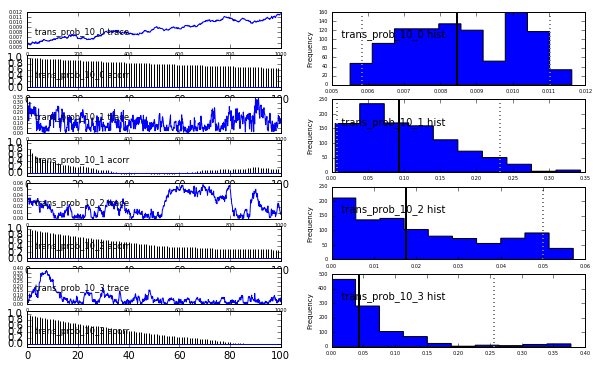

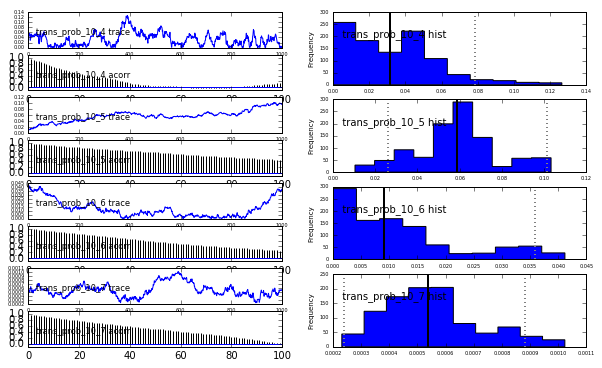

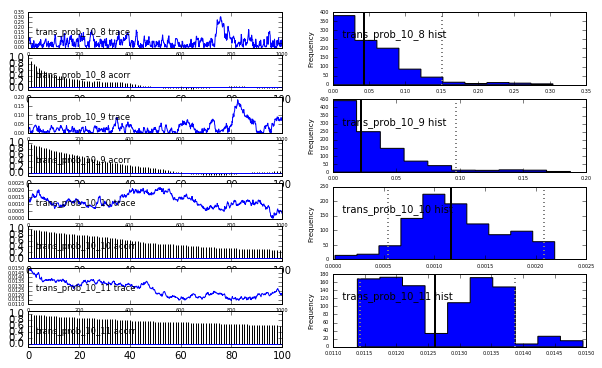

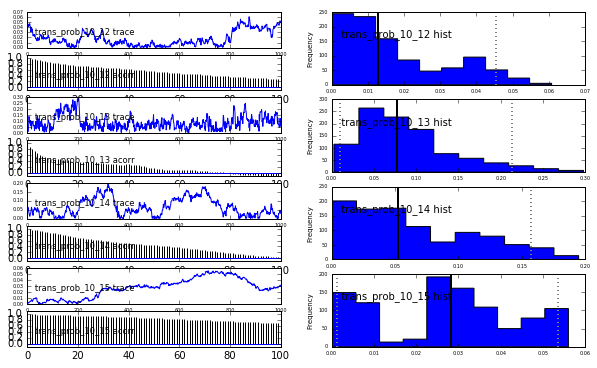

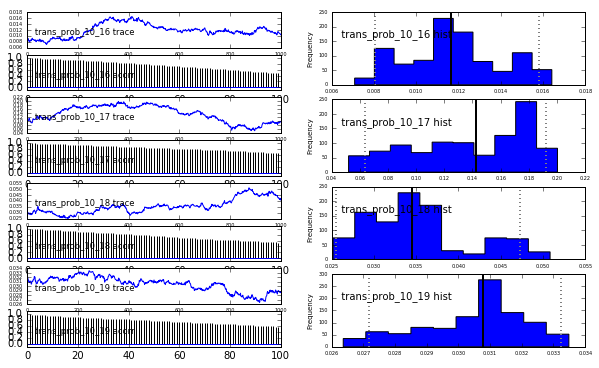

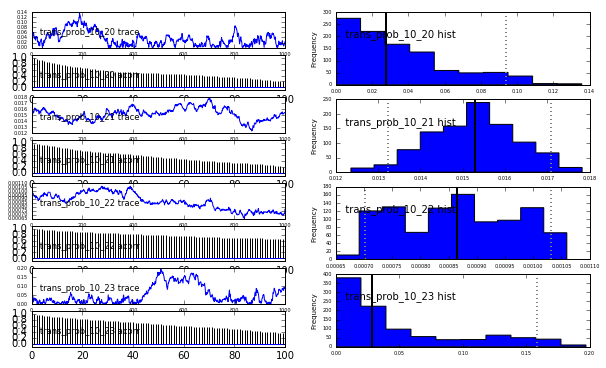

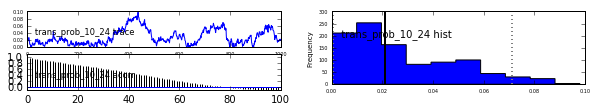

In [37]:
mcplot(mcmc.trace('trans_prob_10'), common_scale=False)

Evaluation metric: tour F1

In [24]:
@jit
def calc_F1score(seq_act, seq_rec):
    #assert(len(seq_act) > 2)
    #assert(len(seq_rec) > 2)

    act_set = set(seq_act)
    rec_set = set(seq_rec)
    intersect = act_set & rec_set
    
    recall    = len(intersect) / len(act_set)
    precision = len(intersect) / len(rec_set)
    F1score   = 2. * precision * recall / (precision + recall)
  
    return F1score

Expected loss for a specific possible trajectory.  
Loss-function: define the loss as $1-\text{tour_F1}$.

In [25]:
def loss_func(seq_true, seq_rec):
    return 1 - calc_F1score(seq_true, seq_rec)

In [26]:
def loss_func2(seq_true, seq_rec):
    set_true = set(seq_true[1:-1])
    set_rec = set(seq_rec[1:-1])
    return (len(set_true) - len(set_true & set_rec))**2

For a specific constraint $(\text{startPOI}, \text{endPOI}, \text{nPOI})$:
1. Compute all possible trajectories that satisfy the above contraint.
1. For each sample of parameters, i.e. transition probabilities of a Markov Chain, compute the most likely trajectory that satisfies the above constraint, so there are $N$ trajectories for $N$ samples.
1. For each possible trajectory computed in the first step, calculate the expected loss over the above $N$ trajectories, choose the one with minimum expected loss to recommend.

Enumerate all possible trajectories that satisfy constraint $(\text{startPOI}, \text{endPOI}, \text{nPOI})$.

In [27]:
def seq_generator_perm(poi_list, startPOI, endPOI, nPOI):
    """
    A generator that enumerates all possible subset of poi_list without startPOI and endPOI,
    The size of subset is nPOI-2
    """
    assert(nPOI > 2)
    assert(nPOI < len(poi_list))
    # NOTE: for ordered sequence, permutations instead of combinations should be used
    #tuples = itertools.combinations([p for p in poi_list if p not in {startPOI, endPOI}], nPOI-2)
    tuples = itertools.permutations([p for p in poi_list if p not in {startPOI, endPOI}], nPOI-2)
    for t in tuples:
        yield [startPOI] + list(t) + [endPOI]

In [28]:
def seq_generator_comb(poi_list, startPOI, endPOI, nPOI):
    assert(nPOI > 2)
    assert(nPOI < len(poi_list))
    # NOTE: for lost function that doesn't care about order, combinations should be used for computation efficiency
    tuples = itertools.combinations([p for p in poi_list if p not in {startPOI, endPOI}], nPOI-2)
    for t in tuples:
        yield [startPOI] + list(t) + [endPOI]

Compute the (log) transition matrices corresponding to all MCMC samples.

In [29]:
def log_transmat_samples(mcmc, poi_id_dict):
    log_transmats = []
    npoi = len(poi_id_dict)
    nsamples = len(mcmc.trace('trans_prob_0')[:])
    for i in range(nsamples):
        mat = np.zeros((npoi, npoi), dtype=np.float)
        log_transmats.append(mat)
    for j in range(npoi):
        samples_j = mcmc.trace('trans_prob_%d' % j)[:]
        assert(len(samples_j) == nsamples)
        for i in range(nsamples):
            # PyMC2 only gives the first k−1 elements for a k components Dirichlet, 
            # the remaining component is assumed to be 1 minus the sum of the first k−1 elements
            log_transmats[i][j, :-1] = np.log(samples_j[i]) # the first k-1 elements
            log_transmats[i][j, -1] = np.log(1 - samples_j[i].sum()) # the last element
    return log_transmats

Compute the most likely trajectory for a given Markov Chain/transition matrix.

In [30]:
def most_likely_seq(log_transmat, possible_seq_generator, poi_id_dict):
    seq_ = None
    maxloglike = -np.inf
    for seq in possible_seq_generator:
        loglike = 0
        for j in range(len(seq)-1):
            pid1 = poi_id_dict[seq[j]]
            pid2 = poi_id_dict[seq[j+1]]
            loglike += log_transmat[pid1, pid2]
        if loglike > maxloglike:
            maxloglike = loglike
            seq_ = seq
    return seq_

In [31]:
import pulp
def most_likely_seq_ILP(log_transmat, startPOI, endPOI, nPOI, poi_id_dict):
    assert(nPOI > 2)
    p0 = str(poi_id_dict[startPOI]); pN = str(poi_id_dict[endPOI]); N = len(poi_id_dict)
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in range(N)] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMaximize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    for pi in [x for x in pois if x != pN]:
        for pj in [y for y in pois if y != p0]: 
            objlist.append(visit_vars[pi][pj] * log_transmat[int(pi), int(pj)])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == nPOI-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
                pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'Connected_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'LeaveAtMostOnce_' + pk
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'EnterAtMostOnce_' + pk
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    
    # solve problem
    #pb.solve() # using PuLP's default solver
    pb.solve(pulp.PULP_CBC_CMD(options=['-threads', '7', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    #pb.solve(pulp.GLPK_CMD()) # GLPK
    #gurobi_options = [('TimeLimit', '7200'), ('Threads', '18'), ('NodefileStart', '0.9'), ('Cuts', '2')]
    #pb.solve(pulp.GUROBI_CMD(options=gurobi_options)) # GUROBI
    
    #print('status:', pulp.LpStatus[pb.status]) # print the status of the solution
    #print('obj:', pulp.value(pb.objective)) # print the optimised objective function value
    #for v in pb.variables(): # print each variable with it's resolved optimum value
        #if isinstance(v.varValue, float) and v.varValue > 0: print(v.name, '=', v.varValue)
        
    visit_mat = np.zeros((N, N), dtype=np.float)
    for pi in pois:
        for pj in pois: visit_mat[int(pi), int(pj)] = visit_vars[pi][pj].varValue
    
    # build the recommended trajectory
    recseq = [int(p0)]
    while True:
        pi = recseq[-1]
        pj = visit_mat[pi].argmax()
        assert(round(visit_mat[pi, pj]) == 1)
        recseq.append(pj)
        #print(recseq); sys.stdout.flush()
        if pj == int(pN): break
    rdict = {pid: poi for poi, pid in poi_id_dict.items()}
    return [rdict[x] for x in recseq]

In [32]:
#log_transmats = log_transmat_samples(mcmc, poi_id_dict)
#log_transmats[0].sum(axis=1)

In [33]:
seq_ = extract_seq(seqid_set_test0[12], seq_all)
seq_

[23, 28, 16, 24, 4, 8, 30]

In [ ]:
seq_gen = seq_generator(poi_list, seq_[0], seq_[-1], len(seq_))
mseq_ = most_likely_seq(log_transmats[1], seq_gen, poi_id_dict)
mseq_

In [48]:
logl1 = 0
for j in range(len(mseq_)-1): 
    p1 = poi_id_dict[mseq_[j]]
    p2 = poi_id_dict[mseq_[j+1]]
    logl1 += log_transmats[1][p1, p2]
print(logl1)

-9.45333570724


In [49]:
mseq2_ = most_likely_seq_ILP(log_transmats[1], seq_[0], seq_[-1], len(seq_), poi_id_dict)
mseq2_

[23, 21, 6, 25, 1, 8, 30]

In [50]:
logl2 = 0
for j in range(len(mseq2_)-1): 
    p1 = poi_id_dict[mseq2_[j]]
    p2 = poi_id_dict[mseq2_[j+1]]
    logl2 += log_transmats[1][p1, p2]
print(logl2)

-9.45333570724


In [35]:
most_likely_dict = dict()

In [36]:
test_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_test0]

In [37]:
recompute = False

In [38]:
if not recompute and os.path.exists(fmlikeseq):
    most_likely_dict = pickle.load(open(fmlikeseq, 'rb'))
else:
    for si in range(len(log_transmats)):
        print('%d processed' % si); sys.stdout.flush()
        for seq in test_seqs:
            qid = query_id_dict[(seq[0], seq[-1], len(seq))]
            if (qid, si) not in most_likely_dict:
                t0 = time.time()
                #s = most_likely_seq(log_transmats[si], seq_generator(poi_list, seq[0], seq[-1], len(seq)), poi_id_dict)
                #print('LOOP used %.1f sec,' % (time.time() - t0), s, len(seq)); sys.stdout.flush()
                #t1 = time.time()
                #s2 = most_likely_seq_ILP(log_transmats[si], seq[0], seq[-1], len(seq), poi_id_dict)
                #print('ILP  used %.1f sec,' % (time.time() - t1), s2, len(seq)); sys.stdout.flush()
                mlseq = most_likely_seq_ILP(log_transmats[si], seq[0], seq[-1], len(seq), poi_id_dict) \
                        if len(seq) > 6 else \
                        most_likely_seq(log_transmats[si], seq_generator_perm(poi_list, seq[0], seq[-1], len(seq)), \
                                        poi_id_dict)
                most_likely_dict[(qid, si)] = mlseq
    pickle.dump(most_likely_dict, open(fmlikeseq, 'wb'))

Recommend the trajectory with minimum expected loss among all possible trajectories, i.e. satisfies constraint $(\text{startPOI}, \text{endPOI}, \text{nPOI})$.

In [50]:
def recommend_seq(startPOI, endPOI, nPOI, poi_list, query_id_dict, most_likely_dict, nsamples):
    qid = query_id_dict[(startPOI, endPOI, nPOI)]
    seq_rec = None
    min_expected_loss = np.inf
    seqs = []
    expected_losses = []
    for seq in seq_generator_comb(poi_list, startPOI, endPOI, nPOI):
        #losses = [loss_func(most_likely_dict[(qid, si)], seq) for si in range(nsamples)]
        losses = [loss_func2(most_likely_dict[(qid, si)], seq) for si in range(nsamples)]
        expected_loss = np.mean(losses)
        seqs.append(seq)
        expected_losses.append(expected_loss)
        #expected_loss = np.mean(losses) + random.random() # tie-breaking
        #if expected_loss < min_expected_loss:
        #    min_expected_loss = expected_loss
        #    seq_rec = seq
    idx = np.arange(len(seqs))
    np.random.shuffle(idx) # tie-breaking
    seq_ix = None
    for ix in idx:
        if expected_losses[ix] < min_expected_loss:
            min_expected_loss = expected_losses[ix]
            seq_ix = ix
    seq_rec = seqs[seq_ix]
    return seq_rec

Evaluation.

In [51]:
F1scores = []
rec_seqs = []
cnt = len(seqid_set_test0)
for seq in test_seqs:
    print(seq, '->'); sys.stdout.flush()
    t0 = time.time()
    seq_ = recommend_seq(seq[0], seq[-1], len(seq), poi_list, query_id_dict, most_likely_dict, 1000)#len(log_transmats))
    rec_seqs.append(seq_)
    F1 = calc_F1score(seq, seq_)
    F1scores.append(F1)
    cnt -= 1
    print(' '*8, seq_, 'used %.1f sec,' % (time.time() - t0), '%d remain to test' % cnt); sys.stdout.flush()

[16, 4, 22] ->
         [16, 30, 22] used 0.0 sec, 143 remain to test
[27, 23, 11] ->
         [27, 20, 11] used 0.0 sec, 142 remain to test
[16, 4, 30] ->
         [16, 4, 30] used 0.0 sec, 141 remain to test
[8, 16, 4, 22] ->
         [8, 16, 30, 22] used 0.4 sec, 140 remain to test
[21, 27, 11] ->
         [21, 23, 11] used 0.0 sec, 139 remain to test
[30, 22, 6] ->
         [30, 22, 6] used 0.0 sec, 138 remain to test
[30, 22, 28, 23] ->
         [30, 21, 22, 23] used 0.4 sec, 137 remain to test
[23, 28, 16] ->
         [23, 30, 16] used 0.0 sec, 136 remain to test
[17, 2, 14] ->
         [17, 15, 14] used 0.0 sec, 135 remain to test
[16, 11, 23] ->
         [16, 21, 23] used 0.0 sec, 134 remain to test
[16, 22, 23] ->
         [16, 21, 23] used 0.0 sec, 133 remain to test
[7, 30, 8] ->
         [7, 16, 8] used 0.0 sec, 132 remain to test
[23, 28, 16, 24, 4, 8, 30] ->
         [23, 4, 8, 16, 21, 28, 30] used 63.8 sec, 131 remain to test
[7, 16, 4, 8] ->
         [7, 16, 30, 8] used

In [52]:
print(np.mean(F1scores))
print('old:', 0.712409060847)

0.718196097884
old: 0.712409060847


In [53]:
assert(len(test_seqs) == len(rec_seqs))
ncorrect = 0
ntotal = 0
for i in range(len(test_seqs)):
    seq_a = test_seqs[i]
    seq_r = rec_seqs[i]
    ncorrect += len(set(seq_a[1:-1]) & set(seq_r[1:-1]))
    ntotal += len(set(seq_a[1:-1]))
acc = ncorrect / ntotal
print(acc)
print('old:', 0.3671875)

0.3828125
old: 0.3671875
